In [15]:
import os 
import numpy as np
import pandas as pd
import scipy
import sklearn.metrics as skmetrics

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import lightning.pytorch as L
from lightning.pytorch.callbacks import EarlyStopping
import torchmetrics
from torchmetrics.regression import PearsonCorrCoef

aa_alphabet = 'ACDEFGHIKLMNPQRSTVWY' # amino acid alphabet
aa_to_int = {aa: i for i, aa in enumerate(aa_alphabet)} # mapping from amino acid to number

# function to one hot encode sequence
def one_hot_encode(sequence):
    # initialize a zero matrix of shape (len(sequence), len(amino_acids))
    one_hot = torch.zeros(len(sequence), len(aa_alphabet))
    for i, aa in enumerate(sequence):
        # set the column corresponding to the amino acid to 1
        one_hot[i].scatter_(0, torch.tensor([aa_to_int[aa]]), 1)
    return one_hot


# sequence data, comes already batched, so treat accordingly in dataloader (batch_size=1)
class SequenceData(Dataset):
    def __init__(self, csv_file, label_col="ddG_ML"):
        """
        Initializes the dataset. 
        input:
            csv_file: path to the relevant data file, eg. "/home/data/mega_train.csv"
        """
        self.df = pd.read_csv(csv_file, sep=",")
        self.label_col = label_col
        # only have mutation rows
        self.df = self.df[self.df.mut_type!="wt"]
        # process the mutation row
        self.df["mutation_pos"] = self.df["mut_type"].apply(lambda x: int(x[1:-1])-1) # make position start at zero
        self.df["mutation_to"] = self.df["mut_type"].apply(lambda x: aa_to_int[x[-1]]) # give numerical label to mutation

        # group by wild type
        self.df = self.df.groupby("WT_name").agg(list)
        # get wild type names
        self.wt_names = self.df.index.values
        # precompute one-hot encoding for faster training
        self.encoded_seqs = {}
        for wt_name in self.wt_names:
            # get the correct row
            mut_row = self.df.loc[wt_name]
            seq = mut_row["wt_seq"][0]
            self.encoded_seqs[wt_name] = one_hot_encode(seq)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get the wild type name
        wt_name = self.wt_names[idx]
        # get the correct row
        mut_row = self.df.loc[wt_name]
        # get the wt sequence in one hot encoding
        sequence_encoding = self.encoded_seqs[wt_name]

        # create mask and target tensors
        mask = torch.zeros((len(sequence_encoding),20)) # will be 1 where we have a measurement
        target = torch.zeros((len(sequence_encoding),20)) # ddg values
        # all mutations from df
        positions = torch.tensor(mut_row["mutation_pos"])
        amino_acids = torch.tensor(mut_row["mutation_to"])
        # get the labels
        labels = torch.tensor(mut_row[self.label_col])

        for i in range(len(sequence_encoding)):
            mask[i,amino_acids[positions==i]] = 1 # one where we have data
            target[i,amino_acids[positions==i]] = labels[positions==i] # fill with ddG values
        
        # returns encoded sequence, mask and target sequence 
        return {"sequence": sequence_encoding[None,:,:].float()[0], "mask": mask, "labels": target}


# usage
dataset_train = SequenceData('/home/course/Downloads/project/project_data/mega_train.csv')
dataset_val= SequenceData('/home/course/Downloads/project/project_data/mega_val.csv')
dataset_test = SequenceData('/home/course/Downloads/project/project_data/mega_test.csv')

# use batch_size=1 bc we treat each sequence as one batch
dataloader_val = DataLoader(dataset_val, batch_size=1, shuffle=False)
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class MyLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MyLSTM,self).__init__()
        
        # input parameters
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        

        # define model layers (LSTM), pseudocode:
        self.LSTM = nn.LSTM(self.input_dim, self.hidden_dim, num_layers = 1, batch_first = True)
        # define full connected layer
        self.fc1 = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self,inp):
        inp1 = inp.to(device)
        h0 = torch.zeros(1, inp.size(0), self.LSTM.hidden_size, dtype=torch.double).to(device)
        c0 = torch.zeros(1, inp.size(0), self.LSTM.hidden_size, dtype=torch.double).to(device)
      #  print("Input shape:", inp.shape)
        #print('inp:', inp1)
      #  print('c0', c0.shape)
      #  print('h0', h0.shape)
        #get output for all time steps
        out, (hn, cn) = self.LSTM(inp1, (h0, c0))
      #  print('out', out.shape)
      #  print('hn', hn.shape)
      #  print('cn', cn.shape)
        #apply fc to all steps
        output= self.fc1(out)
     #   print("output shape:", output.shape)
        return output

####lightning module to train the sequence model
class SequenceModelLightning(L.LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate=0.1):
        super().__init__()
        self.model = MyLSTM(input_dim, hidden_dim, output_dim).double()
        self.learning_rate = learning_rate
        # define loss function here, pseudocode:
        self.loss = nn.MSELoss()

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        input_tensor = batch['sequence'].double()
        target_tensor = batch['labels'].double()
        
        output = self.model(input_tensor)
        loss = self.loss(output, target_tensor)
     #   loss = self.loss(output.view(-1, output.shape[2]),target_tensor.view(-1).long())
        self.log("train_loss", loss, prog_bar=True)
     #   print('training good')
        return loss
    
    def validation_step(self, batch, batch_idx):
        input_tensor = batch['sequence'].double()
        target_tensor = batch['labels'].double()
     #   print("target shape:", target_tensor.shape)
     #   print('batchsize', input_tensor[0].shape)
        output = self.model(input_tensor)
     #   print("output shape:", output.shape)
        loss = self.loss(output, target_tensor)
     #   loss = self.loss(output.view(-1, output.shape[2]),target_tensor[0].view(-1).long())
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
     #   print('validation good')
        return loss
    
    def configure_optimizers(self):
        # define optimizer here
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        return optimizer

In [16]:
# Initialize the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor="val_loss",  # Monitor validation loss
    min_delta=0.00,  # Minimum change to qualify as an improvement
    patience=3,  # Wait 3 epochs without improvement before stopping
    verbose=True,  # Print early stopping messages
    mode="min",  # We want to minimize the loss
    check_finite=True  # Ensure no NaN values in the loss
)

lit_model = SequenceModelLightning(input_dim = 20,
                                  hidden_dim = 10,
                                  output_dim = 20,
                                  learning_rate = .001)

# Define the trainer with early stopping
trainer = L.Trainer(
    devices=1, 
    max_epochs=20,  # Maximum number of epochs
    callbacks=[early_stopping_callback]  # Include the early stopping callback here
)

# Train the model
trainer.fit(lit_model, dataloader_train, dataloader_val)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params | Mode 
------------------------------------------
0 | model | MyLSTM  | 1.5 K  | train
1 | loss  | MSELoss | 0      | train
------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)


/home/course/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/course/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|█| 239/239 [00:01<00:00, 197.46it/s, v_num=61, train_loss=0.6
idation: |                                        | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████| 31/31 [00:00<00:00, 249.19it/s]
Epoch 0: 100%|█| 239/239 [00:01<00:00, 178.33it/s, v_num=61, train_loss=0.6

Metric val_loss improved. New best score: 0.707


Epoch 1: 100%|█| 239/239 [00:01<00:00, 189.90it/s, v_num=61, train_loss=0.2
idation: |                                        | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████| 31/31 [00:00<00:00, 237.79it/s]
Epoch 1: 100%|█| 239/239 [00:01<00:00, 171.19it/s, v_num=61, train_loss=0.2

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.689


Epoch 2: 100%|█| 239/239 [00:01<00:00, 194.60it/s, v_num=61, train_loss=0.7
idation: |                                        | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████| 31/31 [00:00<00:00, 250.03it/s]
Epoch 2: 100%|█| 239/239 [00:01<00:00, 176.01it/s, v_num=61, train_loss=0.7

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.674


Epoch 3: 100%|█| 239/239 [00:01<00:00, 186.48it/s, v_num=61, train_loss=0.6
idation: |                                        | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████| 31/31 [00:00<00:00, 250.03it/s]
Epoch 3: 100%|█| 239/239 [00:01<00:00, 169.35it/s, v_num=61, train_loss=0.6

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.652


Epoch 4: 100%|█| 239/239 [00:01<00:00, 197.52it/s, v_num=61, train_loss=1.4
idation: |                                        | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████| 31/31 [00:00<00:00, 241.23it/s]
Epoch 4: 100%|█| 239/239 [00:01<00:00, 177.78it/s, v_num=61, train_loss=1.4

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.633


Epoch 5: 100%|█| 239/239 [00:01<00:00, 195.01it/s, v_num=61, train_loss=0.6
idation: |                                        | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████| 31/31 [00:00<00:00, 244.14it/s]
Epoch 5: 100%|█| 239/239 [00:01<00:00, 175.93it/s, v_num=61, train_loss=0.6

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.620


Epoch 6: 100%|█| 239/239 [00:01<00:00, 195.73it/s, v_num=61, train_loss=0.4
idation: |                                        | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████| 31/31 [00:00<00:00, 245.01it/s]
Epoch 6: 100%|█| 239/239 [00:01<00:00, 176.63it/s, v_num=61, train_loss=0.4

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.616


Epoch 7: 100%|█| 239/239 [00:01<00:00, 193.63it/s, v_num=61, train_loss=0.7
idation: |                                        | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████| 31/31 [00:00<00:00, 263.96it/s]
Epoch 7: 100%|█| 239/239 [00:01<00:00, 176.14it/s, v_num=61, train_loss=0.7

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.608


Epoch 8: 100%|█| 239/239 [00:01<00:00, 200.15it/s, v_num=61, train_loss=0.6
idation: |                                        | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████| 31/31 [00:00<00:00, 241.21it/s]
Epoch 8: 100%|█| 239/239 [00:01<00:00, 179.86it/s, v_num=61, train_loss=0.6

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.604


Epoch 9: 100%|█| 239/239 [00:01<00:00, 195.56it/s, v_num=61, train_loss=0.4
idation: |                                        | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████| 31/31 [00:00<00:00, 243.74it/s]
Epoch 9: 100%|█| 239/239 [00:01<00:00, 176.33it/s, v_num=61, train_loss=0.4

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.600


Epoch 10: 100%|█| 239/239 [00:01<00:00, 196.63it/s, v_num=61, train_loss=0.
idation: |                                        | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████| 31/31 [00:00<00:00, 242.92it/s]
Epoch 10: 100%|█| 239/239 [00:01<00:00, 177.17it/s, v_num=61, train_loss=0.

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.597


Epoch 11: 100%|█| 239/239 [00:01<00:00, 195.97it/s, v_num=61, train_loss=0.
idation: |                                        | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████| 31/31 [00:00<00:00, 253.26it/s]
Epoch 12: 100%|█| 239/239 [00:01<00:00, 194.72it/s, v_num=61, train_loss=0.
idation: |                                        | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████| 31/31 [00:00<00:00, 245.97it/s]
Epoch 12: 100%|█| 239/239 [00:01<00:00, 175.88it/s, v_num=61, train_loss=0.

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.595


Epoch 13: 100%|█| 239/239 [00:01<00:00, 197.47it/s, v_num=61, train_loss=0.
idation: |                                        | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████| 31/31 [00:00<00:00, 247.56it/s]
Epoch 13: 100%|█| 239/239 [00:01<00:00, 178.20it/s, v_num=61, train_loss=0.

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.591


Epoch 14: 100%|█| 239/239 [00:01<00:00, 198.10it/s, v_num=61, train_loss=0.
idation: |                                        | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████| 31/31 [00:00<00:00, 252.33it/s]
Epoch 14: 100%|█| 239/239 [00:01<00:00, 178.91it/s, v_num=61, train_loss=0.

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.589


Epoch 15: 100%|█| 239/239 [00:01<00:00, 198.42it/s, v_num=61, train_loss=0.
idation: |                                        | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████| 31/31 [00:00<00:00, 255.42it/s]
Epoch 16: 100%|█| 239/239 [00:01<00:00, 195.07it/s, v_num=61, train_loss=0.
idation: |                                        | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████| 31/31 [00:00<00:00, 253.88it/s]
Epoch 17: 100%|█| 239/239 [00:01<00:00, 192.80it/s, v_num=61, train_loss=0.
idation: |                                        | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████| 31/31 [00:00<00:00, 238.96it/s]
Epoch 17: 100%|█| 239/239 [00:01<00:00, 173.84it/s, v_num=61, train_loss=0.

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.588


Epoch 18: 100%|█| 239/239 [00:01<00:00, 196.00it/s, v_num=61, train_loss=0.
idation: |                                        | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████| 31/31 [00:00<00:00, 255.62it/s]
Epoch 18: 100%|█| 239/239 [00:01<00:00, 177.55it/s, v_num=61, train_loss=0.

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.587


Epoch 19: 100%|█| 239/239 [00:01<00:00, 198.15it/s, v_num=61, train_loss=0.
idation: |                                        | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████| 31/31 [00:00<00:00, 247.53it/s]
Epoch 19: 100%|█| 239/239 [00:01<00:00, 178.70it/s, v_num=61, train_loss=0.

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.585
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|█| 239/239 [00:01<00:00, 178.28it/s, v_num=61, train_loss=0.


Pearson r: PearsonRResult(statistic=0.5439780674154717, pvalue=0.0)
Spearman r: SignificanceResult(statistic=0.5065578096709533, pvalue=0.0)
RMSE: 0.6109867313617093


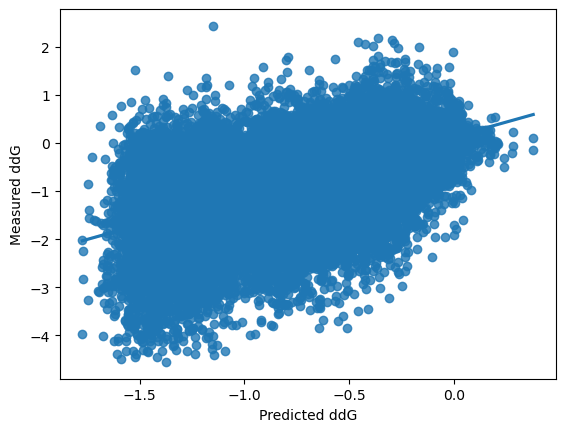

In [17]:
# Define device
device = torch.device("cpu")  # Force CPU

# Move the model to the CPU
lit_model.to(device)

preds = []
all_y = []

for batch in dataloader_val:
    # read from batch
    x = batch["sequence"].to(device)  # Move input tensor to CPU
    mask = batch["mask"].to(device)    # Move mask tensor to CPU
    target = batch["labels"].to(device)  # Move target tensor to CPU

   # print('seq', x.shape)
   # print('mask', mask.shape)
   # print('target', target.shape)

    # Convert input tensor to Double
    x = x.double()

    # predict
    prediction = lit_model(x)

    # Move tensors to CPU and convert to NumPy arrays
    preds.append(prediction[mask == 1].flatten().cpu().detach().numpy())
    all_y.append(target[mask == 1].flatten().cpu().detach().numpy())

# Concatenate and plot
preds = np.concatenate(preds)
all_y = np.concatenate(all_y)

sns.regplot(x=preds, y=all_y)
plt.xlabel("Predicted ddG")
plt.ylabel("Measured ddG")

# Get RMSE, Pearson, and Spearman correlation
print("Pearson r:", scipy.stats.pearsonr(preds, all_y))
print("Spearman r:", scipy.stats.spearmanr(preds, all_y))
print("RMSE:", skmetrics.mean_squared_error(all_y, preds,))

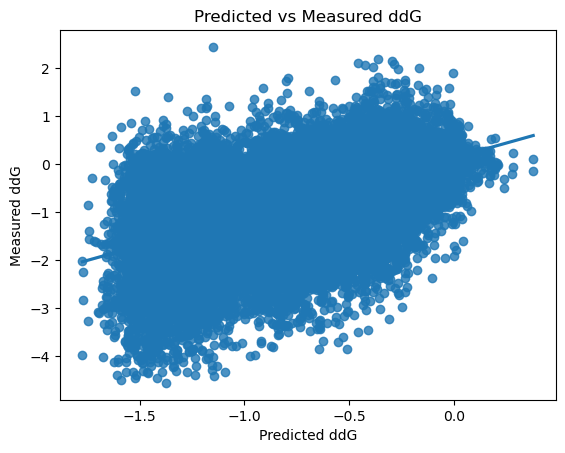

Pearson r: PearsonRResult(statistic=0.5439780674154717, pvalue=0.0)
Spearman r: SignificanceResult(statistic=0.5065578096709533, pvalue=0.0)
RMSE: 0.6109867313617093


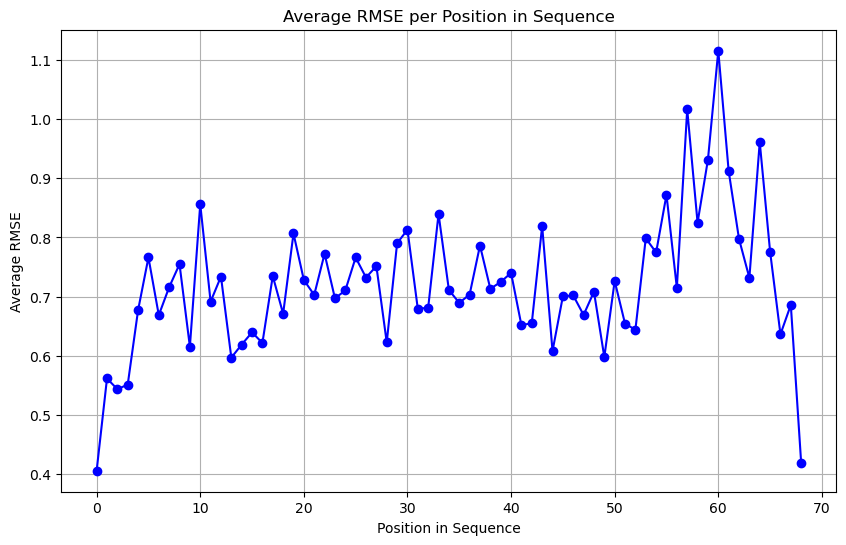

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import sklearn.metrics as skmetrics
import os 
import numpy as np
import pandas as pd
import scipy
import sklearn.metrics as skmetrics

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import lightning.pytorch as L
from lightning.pytorch.callbacks import EarlyStopping
import torchmetrics
from torchmetrics.regression import PearsonCorrCoef
# Define device
device = torch.device("cpu")  # Force CPU

# Move the model to the CPU
lit_model.to(device)

# Initialize lists for predictions and targets
preds = []
all_y = []

# Initialize a list to store RMSE for each position
position_rmse = []

# Validation loop
for batch in dataloader_val:
    # Read from batch
    x = batch["sequence"].to(device)  # Move input tensor to CPU
    mask = batch["mask"].to(device)    # Move mask tensor to CPU
    target = batch["labels"].to(device)  # Move target tensor to CPU

    # Convert input tensor to Double
    x = x.double()

    # Predict
    prediction = lit_model(x)  # Shape: (batch_size, sequence_length, 1)

    # Move tensors to CPU and convert to NumPy arrays
    preds.append(prediction[mask == 1].flatten().cpu().detach().numpy())
    all_y.append(target[mask == 1].flatten().cpu().detach().numpy())

    # Compute RMSE for each position in the sequence
    for pos in range(prediction.shape[1]):  # Iterate over sequence positions
        # Get predictions and targets for the current position
        pred_pos = prediction[:, pos, :]  # Shape: (batch_size, 1)
        target_pos = target[:, pos, :]   # Shape: (batch_size, 1)
        mask_pos = mask[:, pos, :]       # Shape: (batch_size, 1)

        # Compute RMSE only for masked positions
        if mask_pos.sum() > 0:  # Check if there are any valid targets at this position
            rmse_pos = torch.sqrt(torch.mean((pred_pos[mask_pos == 1] - target_pos[mask_pos == 1]) ** 2))
            position_rmse.append((pos, rmse_pos.item()))

# Concatenate predictions and targets
preds = np.concatenate(preds)
all_y = np.concatenate(all_y)

# Plot regression plot
sns.regplot(x=preds, y=all_y)
plt.xlabel("Predicted ddG")
plt.ylabel("Measured ddG")
plt.title("Predicted vs Measured ddG")
plt.show()

# Get RMSE, Pearson, and Spearman correlation
print("Pearson r:", scipy.stats.pearsonr(preds, all_y))
print("Spearman r:", scipy.stats.spearmanr(preds, all_y))
print("RMSE:", skmetrics.mean_squared_error(all_y, preds))

# Convert RMSE values to a structured format
position_rmse_dict = {}
for pos, rmse in position_rmse:
    if pos not in position_rmse_dict:
        position_rmse_dict[pos] = []
    position_rmse_dict[pos].append(rmse)

# Compute average RMSE for each position
avg_rmse_per_position = {pos: np.mean(rmses) for pos, rmses in position_rmse_dict.items()}

# Sort positions and get corresponding average RMSE values
sorted_positions = sorted(avg_rmse_per_position.keys())
sorted_avg_rmse = [avg_rmse_per_position[pos] for pos in sorted_positions]

# Plot the average RMSE for each position
plt.figure(figsize=(10, 6))
plt.plot(sorted_positions, sorted_avg_rmse, marker='o', linestyle='-', color='b')
plt.xlabel("Position in Sequence")
plt.ylabel("Average RMSE")
plt.title("Average RMSE per Position in Sequence")
plt.grid(True)
plt.show()